In [1]:

# =============================================================================
# 
import os
import netCDF4 as nc
import pandas as pd

import numpy as np
import numpy.ma as ma

import xarray as xr

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.style as mplstyle
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import netCDF4 as nc
from netCDF4 import Dataset
import shapefile
import time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns  # 引入seaborn

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import geopandas as gpd
import os
import cartopy.crs as ccrs

import geopandas as gpd
import matplotlib.pyplot as plt

import cmaps
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm

In [ ]:
# 创建映射字典
texture_mapping = {
    1: 'Sand',
    2: 'Loamy Sand',
    3: 'Silt',
    4: 'Sandy Loam',
    5: 'Loam',
    6: 'Silt Loam',
    7: 'Sandy Clay Loam',
    8: 'Clay Loam',
    9: 'Silty Clay Loam',
    10: 'Sandy Clay',
    11: 'Silty Clay',
    12: 'Clay'
}

def get_letter(i):
    if 0 <= i < 26:
        return chr(ord('a') + i)
    else:
        return None  # 或者你可以选择抛出异常或返回其他值  

def abbre_to_full(abbreviation):
    # 定义缩写到全称的映射字典
    abbreviation_mapping = {
        "RF": "RandomForest",
        "LGBM": "LightGBM",
        "CB": "CSMX",
        "XGB": "XGBoost",
    }

    # 查找缩写对应的全称
    full_name = abbreviation_mapping.get(abbreviation.upper())

    if full_name:
        return full_name
    else:
        return f"未找到 '{abbreviation}' 的全称。"
    
def calculate_ets(obs, pred, threshold):
    H = np.sum((obs <= threshold) & (pred <= threshold))  # Hits
    F = np.sum((obs > threshold) & (pred <= threshold))   # False Alarms
    M = np.sum((obs <= threshold) & (pred > threshold))   # Misses
    N = len(obs)  # Total number of samples
    C = ((H + F) * (H + M)) / N if N > 0 else 0  # Chance hits
    
    if (np.nanmin(obs) >= threshold) and (np.nanmin(pred) >= threshold):
        # print(np.nanmin(obs), np.nanmin(pred), "np.nan")
        ets = np.nan
    else:
        ets = (H - C) / (H + F + M - C) if (H + F + M - C) > 0 else np.nan  # Avoid division by zero
    return ets

def calculate_df_ets(threshold , dataframe):
    # ETS计算函数
    # 创建ETS_df数据框
    ets_list = []
    # 遍历每一个ID
    for id_val in dataframe['ID'].unique():
        id_data = dataframe[dataframe['ID'] == id_val]
        
        obs = id_data['OBS'].values
        latitude = id_data['Latitude'].iloc[0]
        longitude = id_data['Longitude'].iloc[0]
        
        ets_varID_list = []
        for SMvar in SM_datas:
            SMvar_ets = calculate_ets(obs, id_data[SMvar].values, threshold)
            ets_varID_list.append(SMvar_ets)
        # print('ets_varID_list: ',ets_varID_list)
        ets_list.append([id_val, latitude, longitude, *ets_varID_list])
        # print('ets_list: ',ets_list)
    # 创建ETS_df
    column_names = ['ID', 'Latitude', 'Longitude'] + SM_datas
    ETS_df = pd.DataFrame(ets_list, columns=column_names)
    return ETS_df
    
def calculate_statistics_scipy(dataframe, column_name, use_median=False):
    if use_median:
        # 计算中位数并保留四位小数
        result = dataframe[column_name].median().round(4)
    else:
        # 计算第一四分位数（Q1）和第三四分位数（Q3）
        Q1 = dataframe[column_name].quantile(0.05)
        Q3 = dataframe[column_name].quantile(0.95)
        IQR = Q3 - Q1
        # 移除极端值
        filtered_df = dataframe[(dataframe[column_name] >= Q1) & (dataframe[column_name] <= Q3)]
        # 计算去掉极端值后的平均值，并保留四位小数
        result = filtered_df[column_name].mean().round(4)
    return result
# =============================================================================
# =============================================================================
MODEL_NAME = "CB"
MODEL_FULL_FNAME = abbre_to_full(MODEL_NAME)
SOIL_DEPTH = '10cm'
# 指定文件路径
BASE_PATH = "/home/yfdong/data/work/SMmerge/CN/merge/code/analysis_code/"
DatabasePath = os.path.join(BASE_PATH, 'DataBase')
ModelPath = os.path.join(BASE_PATH, 'Model')
CODE_PATH = os.path.join(BASE_PATH, 'boxplot')
Figure_path = os.path.join(CODE_PATH,"Fig")
# ============================================================================
VarColorsDict = {"FY*":"#DD9B81", "GDS-Daily":"#6495ED", "GAMSR*":"#FFF68F","CAMSR*":"#CDBE70", 
                 "ERA5": "#63B8FF", "ERA5-Land": "#4682B4", "SMCI*": "#FF7F24", 
                 "GLDAS-Noah": "#9ACD32", "GLDAS-CLSM":"#698B22","CLDAS*": "#CD5555", 
                 MODEL_FULL_FNAME: "#8968CD"}
SM_datas = ["GDS-Daily", "FY*", "GAMSR*", "CAMSR*", "CLDAS*" , "GLDAS-CLSM", "GLDAS-Noah", "ERA5-Land" ,"ERA5" ,"SMCI*" ,MODEL_NAME,'OBS']


In [3]:
# 读取数据
# =============================================================================
# 读取数据文件
db_filename = f"merged_test_SM_{MODEL_NAME}_{SOIL_DEPTH}_GDS_Daily_AMSR_FY.csv"
db_file = os.path.join(DatabasePath, db_filename)
CN_db_df = pd.read_csv(db_file)
basin_shp = gpd.read_file("/home/yfdong/data/map/九大流域/China_nine_basin.shp")
# =============================================================================
print(len(CN_db_df))

/tmp/ipykernel_388986/732148237.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  CN_db_df = pd.read_csv(db_file)


398144


In [ ]:
# draw_ETSdrought_subplot_alldataCN_new.py
# =============================================================================
start = time.time()
BN_db_df = pd.read_csv(os.path.join(DatabasePath , "merged_test_CN_basins_TH.csv"), dtype={'ID': str}, usecols=["ID", "Date","BD","TH", 'Texture'])
# CN_db_df = pd.read_csv(os.path.join(DatabasePath , "merged_test_SM_withBASIN.csv"), dtype={'ID': str})

# CN_db_df = pd.read_csv(os.path.join(DatabasePath,f"merged_test_SM_{MODEL_NAME}_10cm_AMSR_CN.csv"))
db_df_ORI = pd.merge(CN_db_df , BN_db_df, on=["ID", "Date"], how="inner")
db_df_ORI.to_csv(os.path.join(DatabasePath , f"merged_test_SM_TH_{MODEL_NAME}_10cm_AMSR_CN.csv"))

# =============================================================================
# 计算相对土壤湿度
db_df = db_df_ORI.copy()
for SMvar in SM_datas:
    db_df[SMvar] = ((db_df_ORI[SMvar] )  / db_df_ORI["TH"] ) * 100
# print(db_df.columns)
RSM_db_df = db_df.copy()
RSM_db_df.to_csv(os.path.join(DatabasePath,f"RSM_db_df_{MODEL_NAME}_AMSR_CN.csv" ))
# print(RSM_db_df[RSM_db_df['ID']=='52855'])
# =============================================================================
# 
# 将 'Date' 列转换为 datetime 类型
db_df['Date'] = pd.to_datetime(db_df['Date'])

# 定义筛选日期范围的函数
def filter_by_months(df, start_month=4, end_month=8, year=2017):
    # 提取月份
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    # 筛选指定月份的行
    filtered_df = df[(df['Month'] >= start_month) & (df['Month'] <= end_month) & (df['Year'] == year)]
    return filtered_df

# 使用函数筛选数据
filtered_db_df = filter_by_months(db_df)
# =============================================================================
# ----------------------------------计算ETS评分-------------------------------
# 阈值
threshold = 60
dataframe =filtered_db_df

ETS_dfLight = calculate_df_ets(threshold= 60 , dataframe =filtered_db_df)
ETS_dfModerate = calculate_df_ets(threshold= 50 , dataframe =filtered_db_df)
ETS_dfSevere = calculate_df_ets(threshold= 40 , dataframe =filtered_db_df)
ETS_dfExtreme = calculate_df_ets(threshold= 30 , dataframe =filtered_db_df)
# # 如果需要，可以将ETS_df保存到CSV文件

ETS_dfLight.to_csv(os.path.join(DatabasePath, f"ETS_dfLight_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv"))
ETS_dfModerate.to_csv(os.path.join(DatabasePath, f"ETS_dfModerate_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv"))
ETS_dfSevere.to_csv(os.path.join(DatabasePath, f"ETS_dfSevere_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv"))
ETS_dfExtreme.to_csv(os.path.join(DatabasePath,f"ETS_dfExtreme_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv"))

# =============================================================================
# 读取数据
ETS_dfLight = pd.read_csv(os.path.join(DatabasePath, f"ETS_dfLight_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv")) #_AMSR_CN.csv"))
ETS_dfModerate=pd.read_csv(os.path.join(DatabasePath, f"ETS_dfModerate_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv"))
ETS_dfSevere=pd.read_csv(os.path.join(DatabasePath, f"ETS_dfSevere_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv"))
ETS_dfExtreme=pd.read_csv(os.path.join(DatabasePath, f"ETS_dfExtreme_{MODEL_NAME}_GDS_Daily_AMSR_FY.csv"))
# =============================================================================

end = time.time()
print(f"Elapse Time: {end - start}Seconds")


Elapse Time: 51.98308348655701Seconds


In [5]:
column_names = ['ID', 'Latitude', 'Longitude'] + SM_datas
print(column_names )

['ID', 'Latitude', 'Longitude', 'GDS-Daily', 'FY*', 'GAMSR*', 'CAMSR*', 'CLDAS*', 'GLDAS-CLSM', 'GLDAS-Noah', 'ERA5-Land', 'ERA5', 'SMCI*', 'CB', 'OBS']


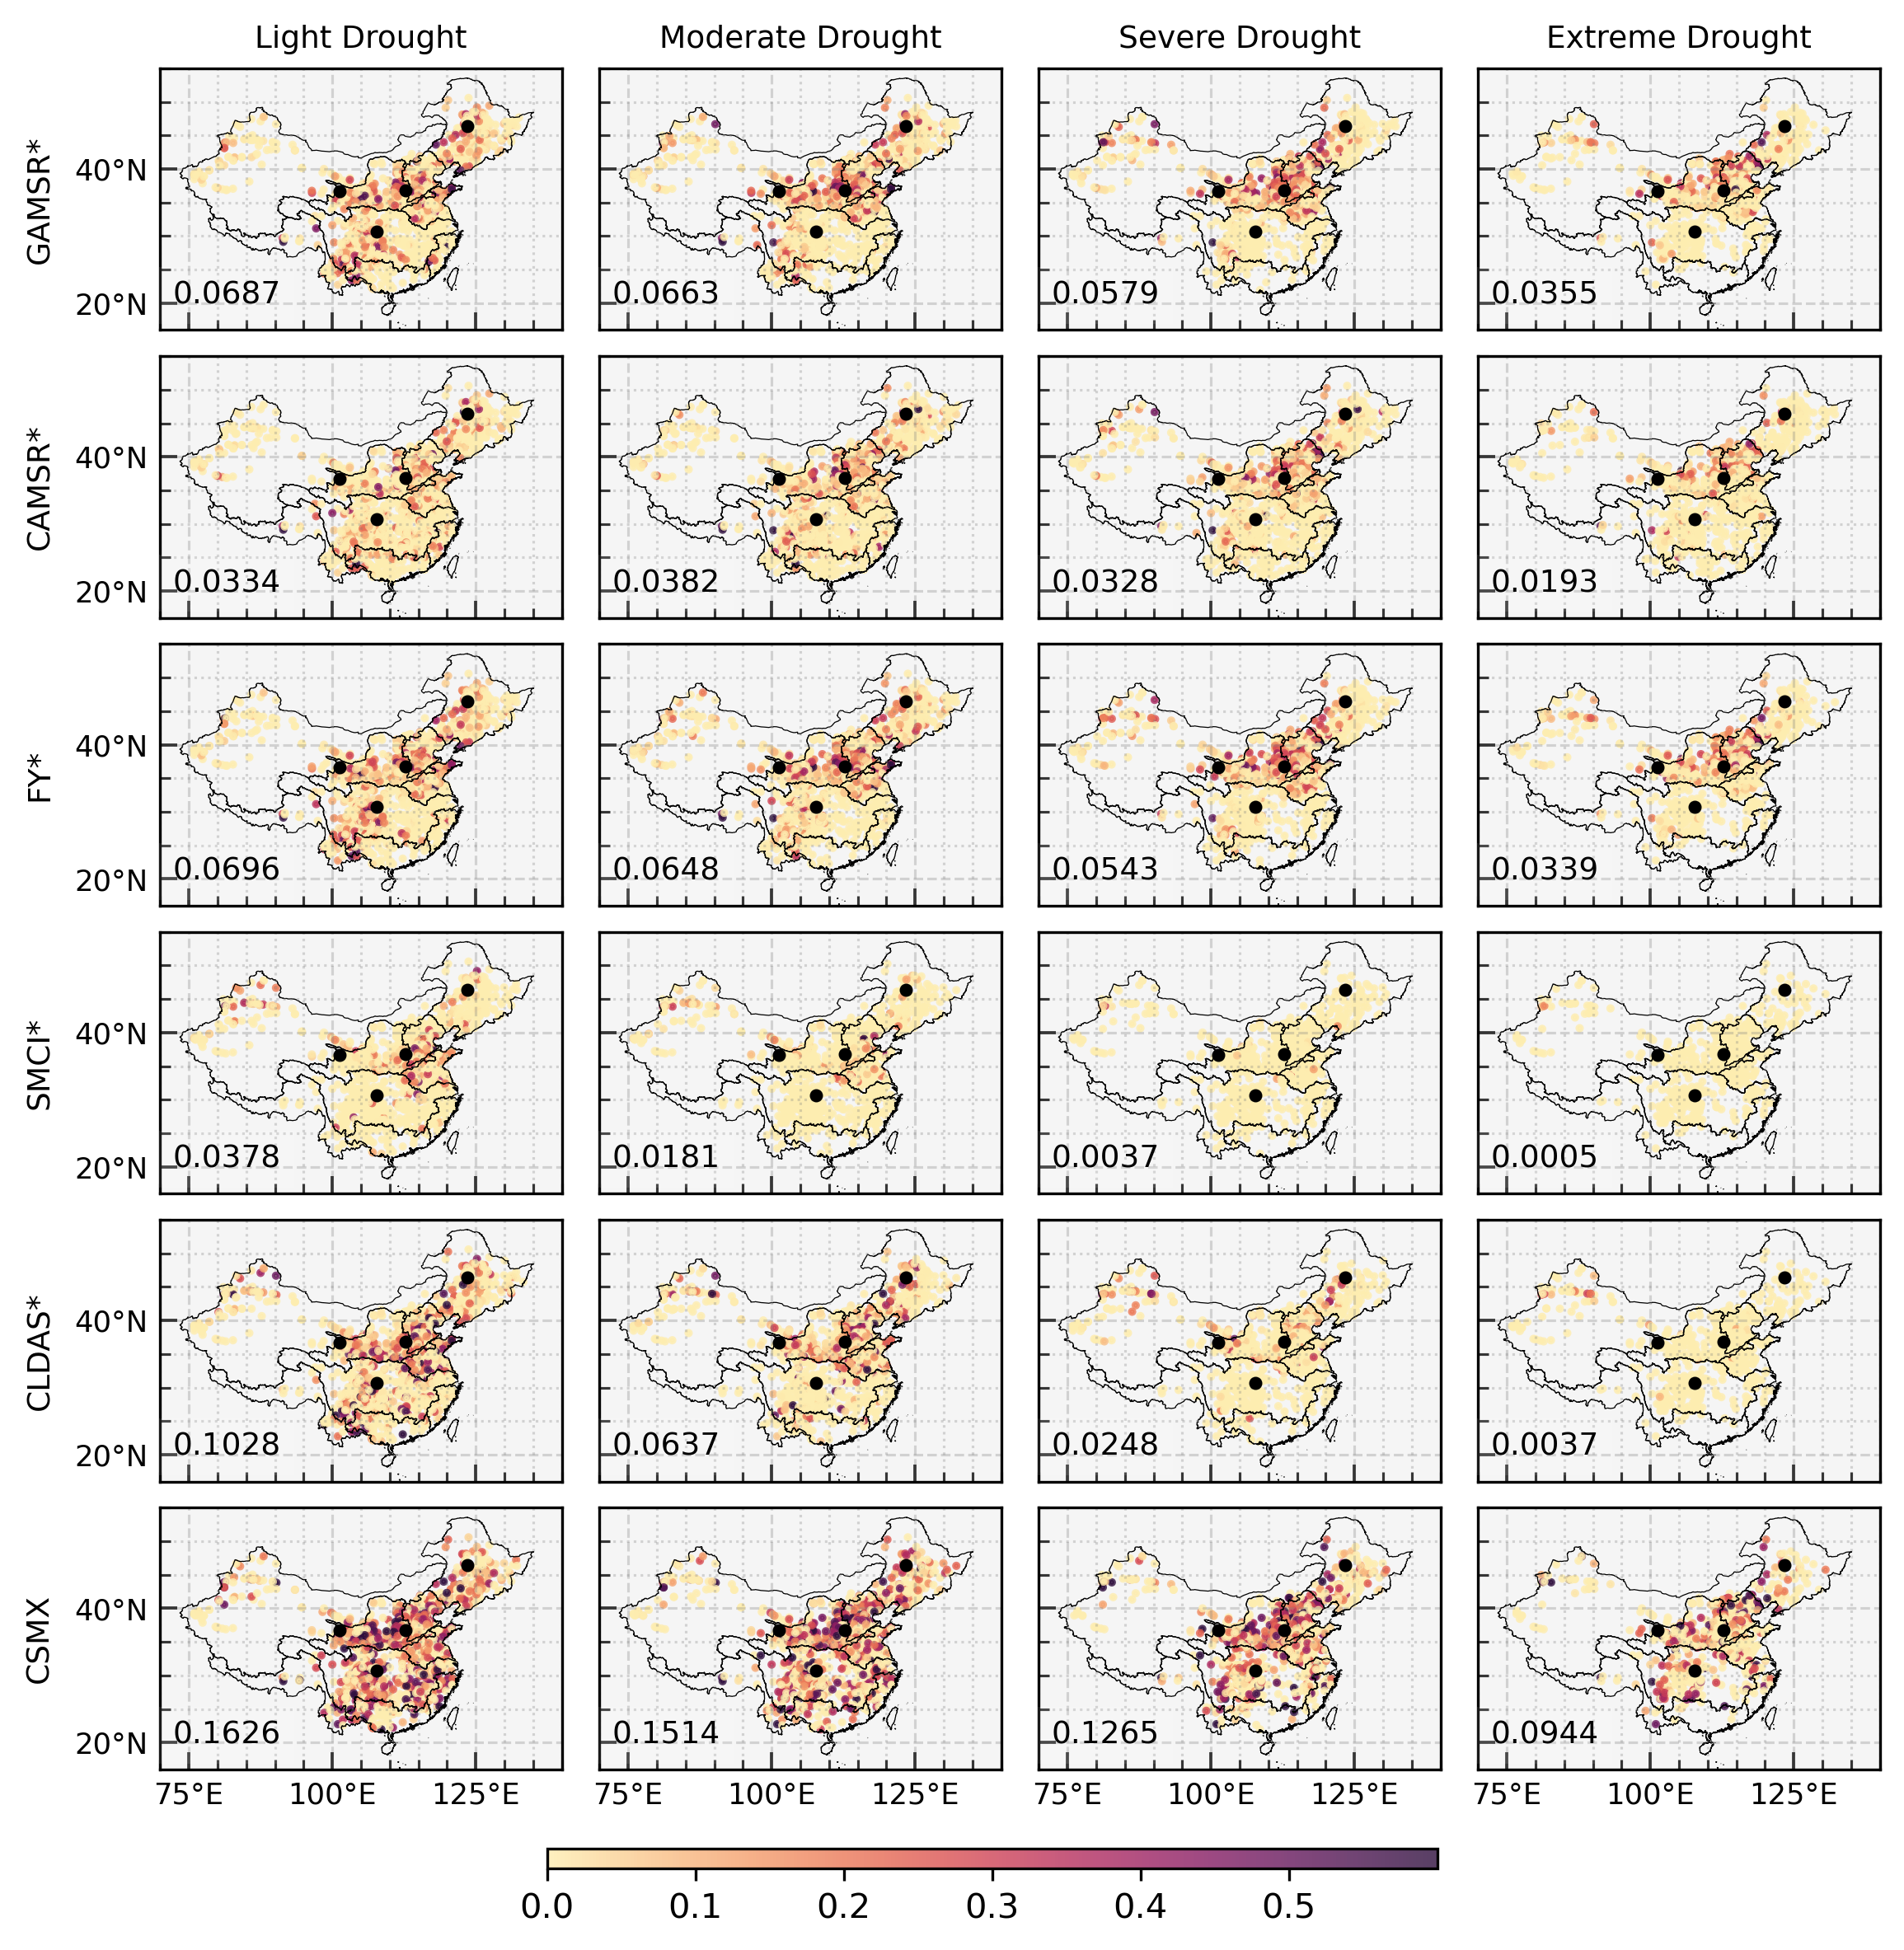

In [ ]:
# ------------------------------可视化---------------------------------------
start_date = "20170731"
end_date = "20170731"
# ETSvars = ["ERA5-Land" ,"GLDAS-CLSM", "GLDAS-Noah", "GAMSR*", "CAMSR*", "GDS-Daily", "FY*", "SMCI*" ,"CLDAS*" , MODEL_NAME]
ETSvars = ["GAMSR*", "CAMSR*", "FY*", "SMCI*" ,"CLDAS*" , MODEL_NAME]
# ETSvars = ["SMCI" ,"CLDAS*" , "CB"]
Nrows = len(ETSvars)
dates = pd.date_range(start=start_date, end=end_date, freq="10D")
# dataframe = ETS_df
xy_lablesize = 9
text_size = 9
cbar_titlesize = 9
cbar_lablesize = 9
sub_titlesize = 9
legend_size = 9
title_size = 9
scatter_size1 = 2
scatter_size2 = 8
# cmap=cmaps.WhiteBlueGreenYellowRed
cmap=cmaps.cmocean_matter
# cmap=cmaps.MPL_coolwarm
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 0.6, vcenter=0.3)
ETSthresholds = [60, 50, 40, 30]
ETSname = ["Light Drought", "Moderate Drought", "Severe Drought","Extreme Drought"]
fig, axs = plt.subplots(nrows=Nrows, ncols=4, figsize=(9, 8/6*Nrows), dpi=300, sharex='all', sharey='all')

# 定义多个站点的经纬度、标记样式和颜色
site_marker = 'D'  # 选择不同的标记样式
site_color = 'red'  # 选择站点的颜色
site_size = 12
# 定义多个站点的经纬度、标记样式和颜色
stations = [
    {'ID':"52855", 'lon': 101.25, 'lat': 36.68, 'marker': 'o', 'color': 'black', 'size': scatter_size2},
    {'ID':"57425", 'lon': 107.78, 'lat': 30.68,'marker': 'o', 'color': 'black', 'size': scatter_size2},
    {'ID':"53872", 'lon': 112.69, 'lat': 36.78,'marker': 'o', 'color': 'black', 'size': scatter_size2},
    {'ID':"H1020", 'lon': 123.45, 'lat': 46.4,'marker': 'o', 'color': 'black', 'size': scatter_size2},

]

IDlist =["52855","57425","53872","54266"]
import cartopy.feature as cfeature

for row, SMvar in enumerate(ETSvars):

    # 遍历每个变量
    for col ,ETSthreshold in enumerate(ETSthresholds):

        if ETSthreshold ==60:
            dataframe= ETS_dfLight
        elif ETSthreshold ==50:
            dataframe= ETS_dfModerate
        elif ETSthreshold ==40:
            dataframe= ETS_dfSevere 
        elif ETSthreshold ==30:
            dataframe= ETS_dfExtreme 
        # 修正获取轴对象的方式
        ax = axs[row, col]  # 之前的代码是ax = axs[idx]，这是不正确的
        # 设置图片大小
        proj = ccrs.PlateCarree()  # 创建投影
        # 设置绘图区背景颜色
        ax.set_facecolor('#F5F5F5')
        # 添加海洋淡蓝色填充，以及海岸线

        scatter_colors = dataframe[SMvar].copy()
        scatters = ax.scatter(dataframe["Longitude"], dataframe["Latitude"], s= scatter_size1, c = scatter_colors, cmap=cmap , norm=norm,alpha= 0.8)

        # 循环绘制多个站点
        for station in stations:
            # print(station)
            ax.scatter(station['lon'], station['lat'], s=station['size'], c=station['color'], marker=station['marker'], edgecolor='black', zorder=5)
        # =============================================================================
        # ---------------------------添加行政区划----------------------------
        

        # 获取Shapefile文件的投影信息
        # shp_crs = basin_shp.crs
        # 设置投影
        # proj = ccrs.Projection(shp_crs)
        # 确保Shapefile与绘图的投影一致
        if basin_shp.crs != 'epsg:4326':
            basin_shp = basin_shp.to_crs('epsg:4326')
        # 添加流域边界
        # ax.add_geometries(basin_shp['geometry'], proj, facecolor='none', edgecolor='black', linewidth=0.5)
        basin_shp.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.3, alpha=1)
        # ---------------------------设置横纵坐标属性----------------------------
        # 设置绘图范围为中国陆地的经纬度范围
        ax.set_xlim(70, 140)
        ax.set_ylim(16, 55)


        # 设置x轴和y轴数字大小和格式
        ax.xaxis.set_major_locator(mticker.FixedLocator(ax.get_xticks()))
        ax.yaxis.set_major_locator(mticker.FixedLocator(ax.get_yticks()))
        
        ax.tick_params(axis='x', labelsize= xy_lablesize-0.5)
        ax.tick_params(axis='y', labelsize= xy_lablesize-0.5)
        xticklabels = [str(int(x)) + '°E' for x in ax.get_xticks()]
        yticklabels = [str(int(y)) + '°N' for y in ax.get_yticks()]
        # 设置横坐标标签
        ax.set_xticklabels(xticklabels)
        # 设置纵坐标标签
        ax.set_yticklabels(yticklabels)
        # 调整刻度线参数：
        ax.minorticks_on()
        # 显示副刻度线
        ax.tick_params(axis="both", which="major", direction="in", width=0.9, length=5, color='#363636')
        ax.tick_params(axis="both", which="minor", direction="in", width=0.75, length=3, color='#363636')
        # 设置主、副刻度线参数
        # grid 设置网格线性
        ax.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75, alpha = 0.3)
        ax.grid(True, which="minor", linestyle=":", color="gray", linewidth=0.75, alpha = 0.3)

        if col==0:
            subtitle =MODEL_FULL_FNAME if ETSvars[row]==MODEL_NAME else ETSvars[row]
            # subtitle =MODEL_NAME
            ax.text(-0.3, 0.5, subtitle, va='center', ha='center', rotation='vertical', 
                    transform=ax.transAxes, fontsize=title_size)
            
        if row==0:
            # ax.set_ylabel(VAR, fontsize= xy_labelsize)
            title_name = ETSname[col]
            ax.set_title(title_name, fontsize=title_size)

        # 添加文本
        METRICvalue = round(np.nanmean(dataframe[SMvar]), 4)
        # 创建文本框，将文本置于文本框内
        bbox = {"facecolor": "white", "alpha": 0.1, "edgecolor": "none"}
        # 所有文本使用统一的样式
        styles = {"size": text_size, "color": "black", "bbox": bbox}
        x , y = 0.3 , 0.1
        text = f"{METRICvalue}"
        # ----------------归一化坐标------------------
        ax.text(x, y, text, ha="right", **styles ,transform = ax.transAxes)
    

# # 保存整个图组为一个文件
# # ----------------------------绘制colorbar----------------------------
# 指定colorbar的位置和大小
cax = fig.add_axes([0.3, 0.05, 0.4, 0.01])
cbar = fig.colorbar(scatters, shrink=0.6,fraction=0.04, pad=0, orientation='horizontal', ax=axs,cax=cax)#, ticks=levels)
# cbar.ax.set_aspect(10)
ticks = np.linspace(0.0, 0.5, 6)
cbar.set_ticks(ticks)
filename = f"drought_ETS_CN2017_{MODEL_NAME}.png"
# 调整子图间距
plt.subplots_adjust( bottom=0.1, top=0.96,wspace=0.08,hspace=0.1)


/tmp/ipykernel_388986/1740033070.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  CN_db_df = pd.read_csv(db_file)


1113598
Index(['Unnamed: 0', 'ID', 'Latitude', 'Longitude', 'Date', 'CLDAS*',
       'GLDAS-Noah', 'ERA5-Land', 'ERA5', 'SMCI*', 'SMC_SM', 'GDS_SM', 'OBS',
       'OBS_SM_30cm', 'OBS_SM_50cm', 'OBS_SM_40cm', 'Prec', 'LST',
       'GLDAS-CLSM', 'CB', 'GDS-Daily', 'BD', 'Texture', 'TH'],
      dtype='object')
Elapse Time: 5.469975233078003Seconds


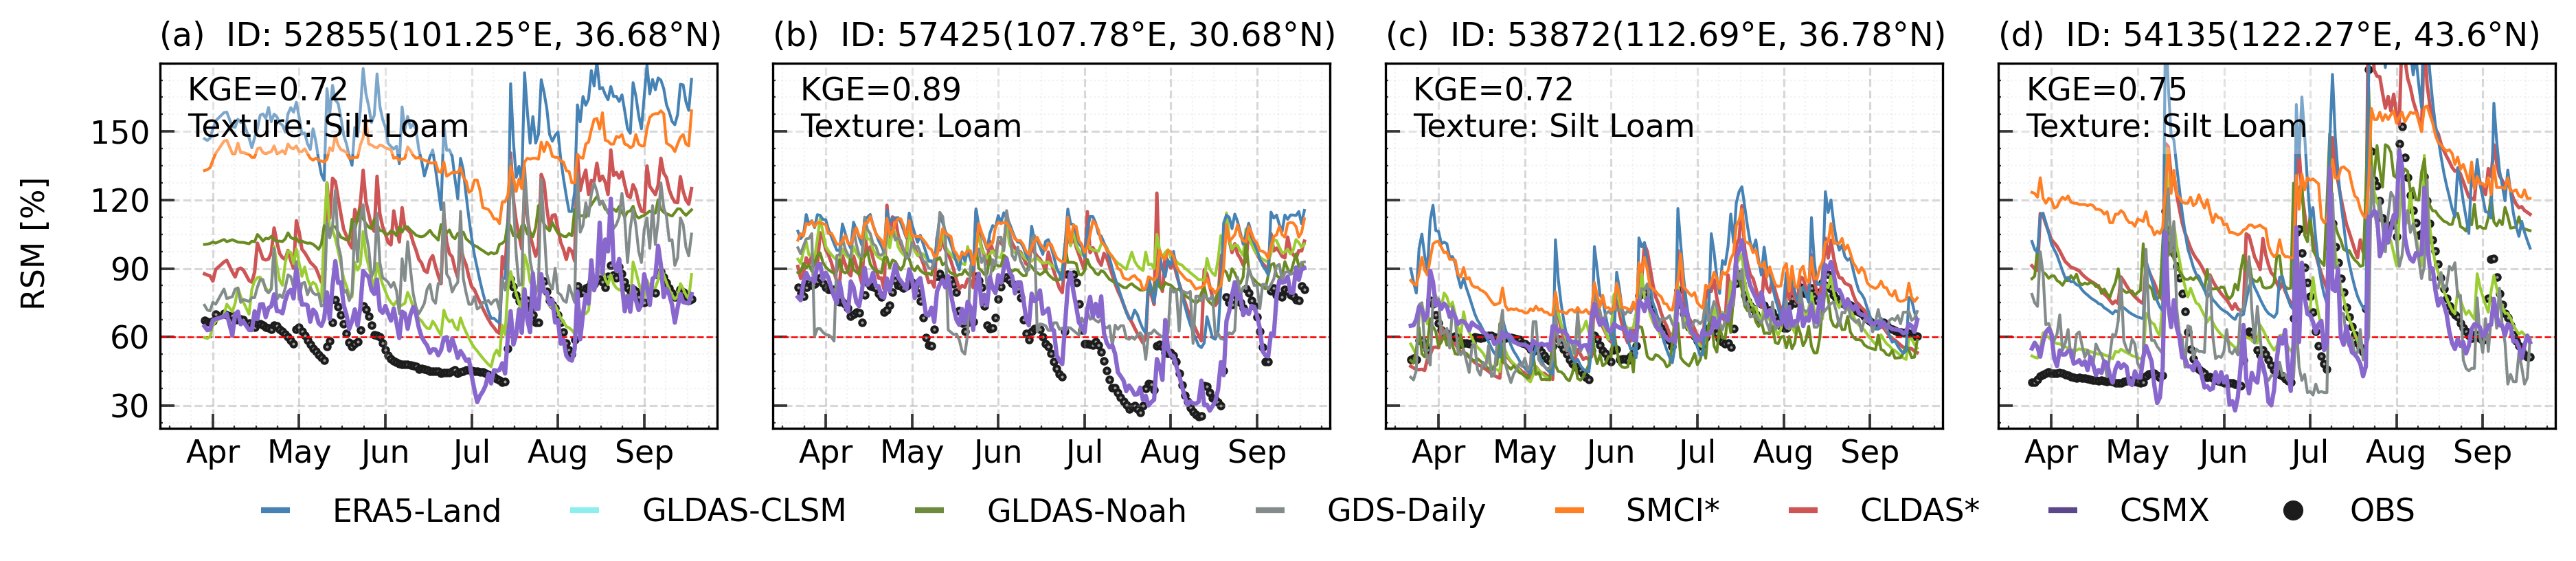

In [ ]:
# 为了保证站点的时间连续性可以不分析未经过gap-filling处理的遥感产品
# =============================================================================

start = time.time()
# 读取数据
# =============================================================================
# 读取数据文件
db_filename = f"merged_test_SM_{MODEL_NAME}_{SOIL_DEPTH}_GDS_Daily.csv"
db_file = os.path.join(DatabasePath, db_filename)
CN_db_df = pd.read_csv(db_file)
basin_shp = gpd.read_file("/home/yfdong/data/map/九大流域/China_nine_basin.shp")
BN_db_df = pd.read_csv(os.path.join(DatabasePath , "merged_test_CN_basins_TH.csv"), dtype={'ID': str}, usecols=["ID", "Date","BD","TH", 'Texture'])
db_df_ORI = pd.merge(CN_db_df , BN_db_df, on=["ID", "Date"], how="inner")
# =============================================================================
print(len(CN_db_df))

# 计算KGE指数
# 计算KGE指数
def calculate_kge(cb, obs):
    mean_cb = cb.mean()
    mean_obs = obs.mean()
    std_cb = cb.std()
    std_obs = obs.std()
    correlation = cb.corr(obs)
    kge = 1 - ((correlation - 1)**2 + (std_cb/std_obs - 1)**2 + (mean_cb/mean_obs - 1)**2)**0.5
    return kge
def filter_stations_by_kge(RSM_db_df, kge_thresholds=[-100., 0.1, 0.2]):
    # 计算每个站点的KGE指数
    RSM_db_df['KGE'] = RSM_db_df.groupby('ID').apply(lambda x: calculate_kge(x['CB'], x['OBS'])).reset_index(level=0, drop=True)
    # 筛选满足条件的站点
    filtered_stations = {}
    for threshold in kge_thresholds:
        stations = RSM_db_df[RSM_db_df['KGE'] > threshold][['ID', 'Longitude', 'Latitude']].drop_duplicates()
        filtered_stations[f'KGE > {threshold}'] = stations
    return filtered_stations,RSM_db_df
db_df = db_df_ORI.copy()
SM_datas = ["GDS-Daily", "CLDAS*" , "GLDAS-CLSM", "GLDAS-Noah", "ERA5-Land" ,"ERA5" ,"SMCI*" ,MODEL_NAME,'OBS']

for SMvar in SM_datas:
    db_df[SMvar] = (((db_df_ORI[SMvar] ) / (db_df_ORI["BD"] * 0.001)) / db_df_ORI["TH"] ) * 100
# print(db_df.columns)
RSM_db_df = db_df.copy()

# 将数字映射为对应的土壤质地名称
RSM_db_df['Texture'] = RSM_db_df['Texture'].map(texture_mapping)
# # 按照ID划分数据集
year = 2017
start_month = 4
end_month = 9
RSM_db_df["Date"] = pd.to_datetime(RSM_db_df["Date"])
# =============================================================================
# 提取四个ID的
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10*1.5, 2.3), dpi=300, sharex='all', sharey='all')
IDlist =["A1254","52863","56697","H1020"]
# =============================================================================    
axplot_linewidth = 1
xy_labelsize = 11
legend_size = 11
axplot_alpha = 1
print(RSM_db_df.columns)
IDlist =["52855","57425","53872","K6601"]
IDlist =["52855","57425","53872","H1020"]
IDlist =["52855","57425","53872","54135"]
# IDlist =["52855","57425","53872","D5803"]
VarColorsDict = {"FY*":"#DD9B81", "GDS-Daily":"#838B8B", "GAMSR*":"#FFF68F","CAMSR*":"#CDBE70", 
                 "ERA5": "#63B8FF", "ERA5-Land": "#4682B4", "SMCI*": "#FF7F24", 
                 "GLDAS-Noah": "#9ACD32", "GLDAS-CLSM":"#698B22","CLDAS*": "#CD5555", 
                 MODEL_FULL_FNAME: "#8968CD"}
for i,ID in enumerate(IDlist):
    # 提取符合日期的所有ID所在的行为ID_df_ORI
    ID_df_ORI = RSM_db_df[(RSM_db_df['Date'].dt.year == year) & (start_month <= RSM_db_df['Date'].dt.month) & (RSM_db_df['Date'].dt.month <= end_month)]
    ID_df = ID_df_ORI[ID_df_ORI['ID'] ==ID ]
    row, col = divmod(i, 4)  # 计算行列索引
    ax = axs[col]  # 获取当前子图的轴
    ID_name = ID
    ID_lat =ID_df["Latitude"].iloc[0]
    ID_lon =ID_df["Longitude"].iloc[0]
    ID_Texture = ID_df["Texture"].iloc[0]
    # Transform Format
    ID_df.loc[:, "Date"] = pd.to_datetime(ID_df["Date"], format="%Y-%m-%d %H:%M:%S")
    # 绘制干旱警戒线
    ax.axhline(y=60, color='red', linewidth=0.60, linestyle='--')

    ax.plot(ID_df["Date"].values, ID_df[f"CLDAS*"].values, color = VarColorsDict["CLDAS*"], linewidth = axplot_linewidth*1.2 , label="CLDAS*")    
    ax.plot(ID_df["Date"].values, ID_df[f"GLDAS-Noah"].values, color = VarColorsDict["GLDAS-Noah"], linewidth = axplot_linewidth , label="GLDAS-Noah") 
    ax.plot(ID_df["Date"].values, ID_df[f"GLDAS-CLSM"].values, color = VarColorsDict["GLDAS-CLSM"], linewidth = axplot_linewidth , label="GLDAS-CLSM") 
    ax.plot(ID_df["Date"].values, ID_df[f"ERA5-Land"].values, color = VarColorsDict["ERA5-Land"], linewidth = axplot_linewidth , label="ERA5-Land")
    ax.plot(ID_df["Date"].values, ID_df[f"GDS-Daily"].values, color = VarColorsDict["GDS-Daily"], linewidth = axplot_linewidth , label="GDS-Daily")
    ax.plot(ID_df["Date"].values, ID_df[f"SMCI*"].values, color = VarColorsDict["SMCI*"], linewidth = axplot_linewidth , label="SMCI*") 
    ax.plot(ID_df["Date"].values, ID_df[MODEL_NAME].values, color = VarColorsDict[MODEL_FULL_FNAME], linewidth = axplot_linewidth*1.5 , label=MODEL_NAME) # purple


    ax.scatter(ID_df["Date"],ID_df["OBS"],facecolors='#9C9C9C', edgecolors= "#1C1C1C", s =4, alpha = 1, label="OBS")
    # 时间标签设置
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=31))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))

    # =============================================================================
    # 
    # 创建文本框，将文本置于文本框内
    bbox = {"facecolor": "white", "alpha": 0.3, "edgecolor": "none"}
    # 所有文本使用统一的样式
    styles = {"size": xy_labelsize, "color": "black", "bbox": bbox}
    x, y = 0.05 , 0.8
    text = f"Lon: {ID_lon}°E, Lat: {ID_lat}°N  \n Texture: {ID_Texture}"
    kge_metric =np.round(calculate_kge(ID_df[MODEL_NAME], ID_df['OBS']),2)
    text = f"KGE={kge_metric}  \nTexture: {ID_Texture}"
    # ----------------归一化坐标------------------
    ax.text(x, y, text, ha="left", **styles ,transform = ax.transAxes)
    letter = get_letter(i)
    ax.set_title(f"({letter})  ID: {ID_name}({ID_lon}°E, {ID_lat}°N)", loc='left', fontsize=xy_labelsize+0.5)
    # =============================================================================

    # 调整刻度线参数：
    ax.minorticks_on()
    # 显示副刻度线
    ax.tick_params(axis="both", which="major", direction="in", width=0.9, length=5, color='#363636')
    ax.tick_params(axis="both", which="minor", direction="in", width=0.55, length=1, color='#363636')

    # grid 设置网格线性
    ax.grid(True, which="major", linestyle="--", color="gray", linewidth=0.75, alpha = 0.3)
    ax.grid(True, which="minor", linestyle=":", color="gray", linewidth=0.55, alpha = 0.1)
      
    # ax.set_ylime()
    # 设置x轴和y轴数字大小
    ax.tick_params(axis='x', labelsize = xy_labelsize)
    ax.tick_params(axis='y', labelsize = xy_labelsize)

    
# Legend
# 调整字体大小
fontprops = fm.FontProperties(size=legend_size)
# =============================================================================
# 添加总的legend
colors = [ "#4682B4", "#8DEEEE", "#6E8B3D",  "#838B8B" , "#FF7F24", "#CD5555",  "#5D478B", "#1C1C1C"]
labels = [ "ERA5-Land", "GLDAS-CLSM", "GLDAS-Noah",  "GDS-Daily", "SMCI*", "CLDAS*", "CSMX", "OBS"]
markers = ['_', '_', '_',  '_', '_', '_', '_','.']  # 设置 OBS 为 'o'，其余为 '_'
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# 创建图例的handles
legend_handles = [mlines.Line2D([], [], color=color, marker=marker, linestyle='None',
                                markersize=10, markeredgewidth=2, label=label)
                  for color, label, marker in zip(colors, labels, markers)]

# 设置字体属性
fontprops = fm.FontProperties(size= legend_size)

# 绘制图例
legend = fig.legend(handles=legend_handles, bbox_to_anchor=(-3.2, -0.35, 4., 0.1),
                    loc='lower center', bbox_transform=ax.transAxes,
                    prop=fontprops, ncol=12, mode='expand', columnspacing=0.05,frameon=False)
# 第一个参数：指定文本框的左下角位置相对于图形区域左下角位置的偏移量，-0.2表示向左偏移0.2倍的图形宽度。
# 第二个参数：指定文本框的左下角位置相对于图形区域左下角位置的偏移量，-0.35表示向下偏移0.35倍的图形高度。
# 第三个参数：指定文本框的宽度，2表示文本框宽度为图形宽度的2倍。
# 第四个参数：指定文本框的高度，0.3表示文本框高度为图形高度的0.3倍。
# =============================================================================
# 标签及坐标轴数字设置

# plt.ylabel('RSM [%]', fontsize=5)
# 在图的右侧设置总的ylabel
fig.supylabel('RSM [%]', fontsize=legend_size, x=0.08)
plt.yticks([30, 60, 90, 120, 150 ])
plt.ylim(20, 180)    
  # Save Files
if not os.path.exists(Figure_path):
        os.makedirs(Figure_path) 
# 调整子图间距
# plt.subplots_adjust(left=0.2 , bottom=0.3, right=0.8,top=0.8,wspace=0.4,hspace=0.3)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
# save_name = os.path.join(Figure_path, f"{year}_{ID_name}.svg")
# plt.savefig(save_name, dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.text(0.05, 0.9, '(b)', fontsize=xy_labelsize, va='top', ha='left')
save_name = os.path.join(Figure_path, f"RSMID_subplot.png")

end = time.time()
print(f"Elapse Time: {end - start}Seconds")
